#Importing Libraries and Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/content/drive/MyDrive/AccAsgn/Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#Exploratory Data Analysis — EDA
## 1. Data cleaning including missing values, outliers and multi-collinearity.

## Checking for missing data

In [3]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
fraud = df[df['isFlaggedFraud']==1]
normal = df[df['isFlaggedFraud']==0]

print(f"Fraudulant transactions Shape: {fraud.shape}")
print(f"Non-Fraudulant transactions Shape: {normal.shape}")

Fraudulant transactions Shape: (8213, 11)
Non-Fraudulant transactions Shape: (6354407, 11)


# Observations
* The dataset is highly imbalanced, with only 0.129% of observations being fraudulent.
* There is no missing data in the dataset
* The dataset consists of 11 features which needed to be transformed


##Checking for multi-collinearity

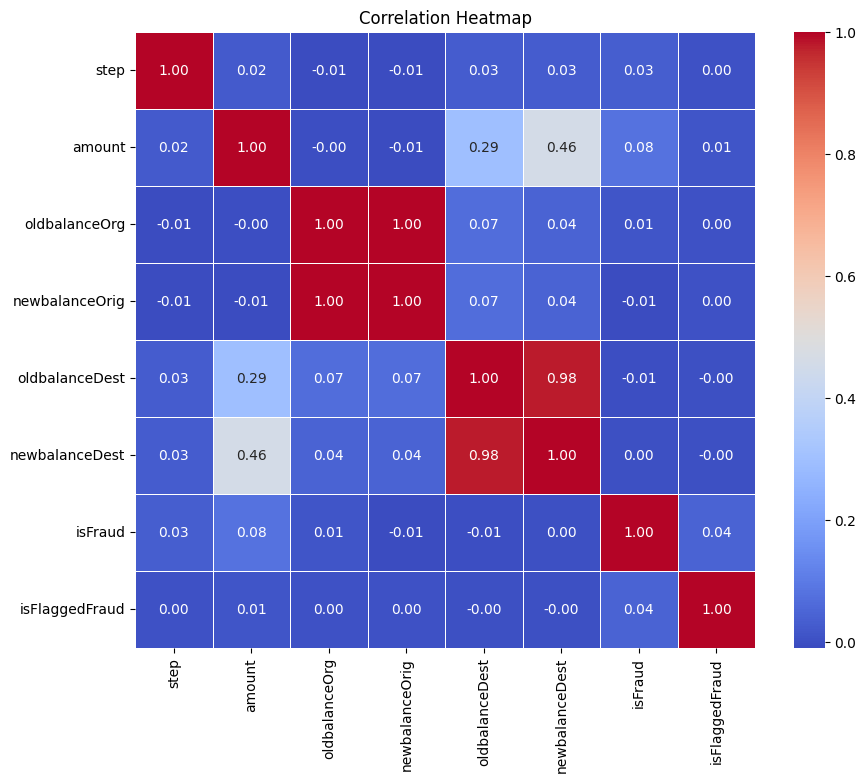

In [5]:
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## 3. How did you select variables to be included in the model?

## Summary and Explanation
* **oldbalanceOrg** and **newbalanceOrg** are perfectly correlated because these two columns represent the original and new balances in the sender's account after the transaction.
* **oldbalanceDest** and **newbalanceDest** are also perfectly correlated because these two columns represent the original and new balances in the recipient's account
* **nameOrig** and **nameDest** are mass categorical variable

## Action
1. Removing **newbalanceOrig** and **newbalanceDest** to avoid multicollinearity
2. Removing **nameOrig** and **nameDest** because of irrelavnce

In [6]:
to_remove = ['newbalanceOrig', 'newbalanceDest', 'nameOrig', 'nameDest']
df_refined = df.drop(columns=to_remove)
df_refined.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,21182.0,1,0
4,1,PAYMENT,11668.14,41554.0,0.0,0,0


### 5. What are the key factors that predict fraudulent customer?
* **step**
* **type**
* **amount**
* **oldbalanceOrg**
* **oldbalanceDest**
* **isFraud**
* **isFlaggedFraud**

---

### 6. Do these factors make sense? If yes, How? If not, How not?
* **Transaction Type (type):** This is a highly relevant factor. Fraudulent transactions often involve types like "TRANSFER" and "CASH_OUT" as they typically move money out of an account.

* **Transaction Amount (amount):** This is crucial. Unusually high or low amounts can be red flags for fraud.

* **Account Balances (oldbalanceOrg, oldbalanceDest):** Changes in account balances are important. Fraudulent transactions may result in significant balance changes.

* **Time (step):** Patterns of transactions at specific times could indicate fraudulent activity. For example, a sudden increase in transactions during off-hours.

# Data Preprocessing
1. Normalizing **amount**, **oldbalanceOrg**, **oldbalanceDest** to avoid dominance of significantly larger values.
2. Applying One Hot Encoding on **type** feature.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


df_refined = pd.get_dummies(df_refined, columns=['type'], drop_first=True)


scaler = StandardScaler()


to_normalize = ['amount', 'oldbalanceOrg', 'oldbalanceDest']
df_refined[to_normalize] = scaler.fit_transform(df_refined[to_normalize])


X = df_refined.drop('isFlaggedFraud', axis=1)
y = df_refined['isFlaggedFraud']


#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Handling Highly Imbalance Dataset


Q Why does class imbalance affect model performance?


*   **Bias Toward Majority Class:** Models tend to favor predicting the majority class due to imbalanced data.

*   **Reduced Sensitivity:** Lower recall for the minority class leads to missed positive cases.

*   **Low Precision:** High false positive rate for the minority class results in low precision.

*   **Difficulty Learning Patterns:** Limited minority class samples make it harder for the model to learn distinguishing features.

*   **Skewed Decision Thresholds:** Some algorithms use thresholds biased toward the majority class.



---


Q What can we do ?
* Training a model on a balanced dataset optimizes performance on validation data.

* We need to find a balance on the imbalanced production dataset that works best.
* One solution to this problem is: Use all fraudulent transactions but subsample non-fraudulent transactions as needed to hit our target rate.

---
##Proposed Approach
I have combined **Oversampling** and **Undersampling** in order to get a balanced dataset.
> Since the dataset has non-fraudulent transaction as majority so I performed Undersampling to reduce the majority data.


> Then I performed Oversampling to increase the minority data.

I applied many combination of both the above strategy but the following one works best for me


In [51]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


undersample = RandomUnderSampler(sampling_strategy='majority')
undersample = RandomUnderSampler(sampling_strategy=0.01)
X_under, y_under = undersample.fit_resample(X, y)

oversample = RandomOverSampler(sampling_strategy='minority')
oversample = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(X_under, y_under)


X_train, X_temp, y_train, y_temp = train_test_split(X_over, y_over, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.7, random_state=42)

In [52]:
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n{'_'*60}")
print(f"VALIDATION: X_validate: {X_val.shape}, y_validate: {y_val.shape}\n{'_'*60}")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (862365, 9), y_train: (862365,)
____________________________________________________________
VALIDATION: X_validate: (110875, 9), y_validate: (110875,)
____________________________________________________________
TESTING: X_test: (258710, 9), y_test: (258710,)


### Code to print result statistics

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        pd.set_option("display.float", "{:.2f}".format)
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy : {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy : {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")

### Weight of the balanced dataset

In [54]:
w_p = y_train.value_counts()[0] / len(y_train)
w_n = y_train.value_counts()[1] / len(y_train)

print(f"Fraudulant transaction weight: {w_n}")
print(f"Non-Fraudulant transaction weight: {w_p}")

class_weight = {0:w_p, 1:w_n}

Fraudulant transaction weight: 0.3335339444434781
Non-Fraudulant transaction weight: 0.6664660555565219


# Model Building
### 2. Describe your fraud detection model in elaboration.
### 4. Demonstrate the performance of the model by using best set of tools.


## Artificial Neural Network

### Model description


*   Model Type: Binary classification neural network.

*   **Architecture:** Sequential model with an input layer, one hidden layer, and an output layer.

*   **Input Layer:** 64 neurons with ReLU activation.

*   **Regularization:** Dropout layers (30% dropout rate) after the input and hidden layers to prevent overfitting.

*   **Hidden Layer:** 32 neurons with ReLU activation.

*   **Output Layer:** Single neuron with sigmoid activation, producing a probability for fraud detection.

*   **Evaluation Metrics:** Custom metrics for True Positives, True Negatives, False Positives, False Negatives, Precision, and Recall.

*   **Model Compilation:** Adam optimizer, binary cross-entropy loss, and custom metrics for evaluation.

*   **Training:** 100 epochs with a batch size of 512, using training and validation data.

*   **Evaluation:** Model performance assessed on test data for fraud detection.



In [55]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

METRICS = [
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('model_at_{epoch}.h5')]

result = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512, callbacks=callbacks, verbose=1)

score = model.evaluate(X_test, y_test)
print(score)

Epoch 1/100
1685/1685 [==============================] - 11s 6ms/step - loss: 0.8676 - fn: 179921.0000 - fp: 47993.0000 - tn: 526744.0000 - tp: 107707.0000 - precision: 0.6918 - recall: 0.3745 - val_loss: 0.3051 - val_fn: 8370.0000 - val_fp: 5006.0000 - val_tn: 68936.0000 - val_tp: 28563.0000 - val_precision: 0.8509 - val_recall: 0.7734
Epoch 2/100
  39/1685 [..............................] - ETA: 6s - loss: 0.3509 - fn: 1958.0000 - fp: 1016.0000 - tn: 12258.0000 - tp: 4736.0000 - precision: 0.8234 - recall: 0.7075

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1685/1685 [==============================] - 8s 5ms/step - loss: 0.3000 - fn: 75063.0000 - fp: 33587.0000 - tn: 541150.0000 - tp: 212565.0000 - precision: 0.8636 - recall: 0.7390 - val_loss: 0.2295 - val_fn: 8261.0000 - val_fp: 1945.0000 - val_tn: 71997.0000 - val_tp: 28672.0000 - val_precision: 0.9365 - val_recall: 0.7763
Epoch 3/100
1685/1685 [==============================] - 9s 5ms/step - loss: 0.2576 - fn: 67132.0000 - fp: 24061.0000 - tn: 550676.0000 - tp: 220496.0000 - precision: 0.9016 - recall: 0.7666 - val_loss: 0.2004 - val_fn: 5879.0000 - val_fp: 2878.0000 - val_tn: 71064.0000 - val_tp: 31054.0000 - val_precision: 0.9152 - val_recall: 0.8408
Epoch 4/100
1685/1685 [==============================] - 8s 5ms/step - loss: 0.2247 - fn: 57986.0000 - fp: 20839.0000 - tn: 553898.0000 - tp: 229642.0000 - precision: 0.9168 - recall: 0.7984 - val_loss: 0.1786 - val_fn: 5540.0000 - val_fp: 2515.0000 - val_tn: 71427.0000 - val_tp: 31393.0000 - val_precision: 0.9258 - val_recall: 0.8500
E

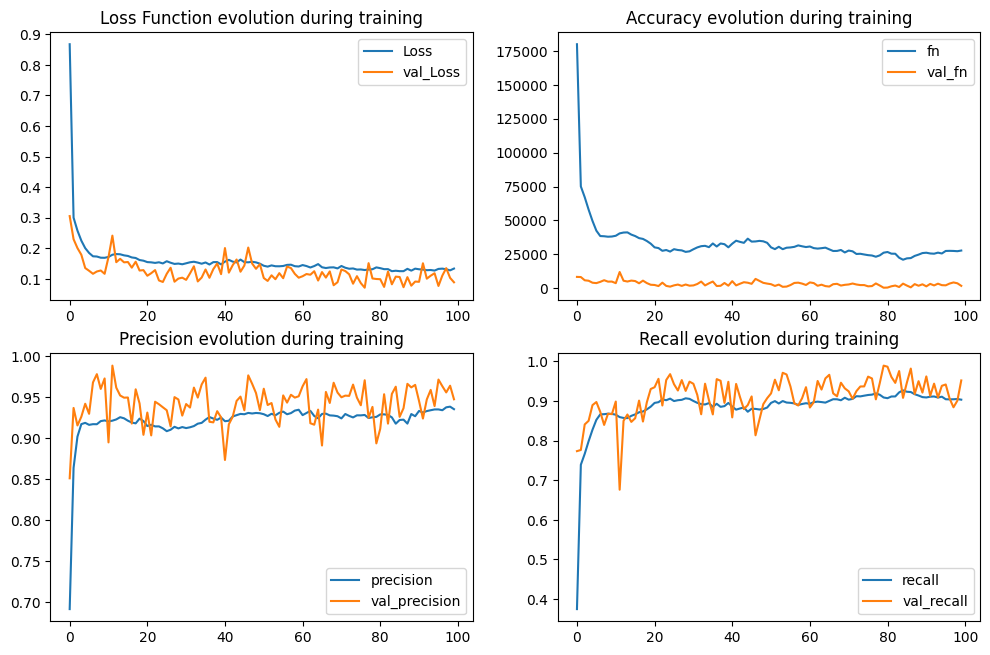

In [56]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(result.history['loss'], label='Loss')
plt.plot(result.history['val_loss'], label='val_Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(result.history['fn'], label='fn')
plt.plot(result.history['val_fn'], label='val_fn')
plt.title('Accuracy evolution during training')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(result.history['precision'], label='precision')
plt.plot(result.history['val_precision'], label='val_precision')
plt.title('Precision evolution during training')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(result.history['recall'], label='recall')
plt.plot(result.history['val_recall'], label='val_recall')
plt.title('Recall evolution during training')
plt.legend()

## ANN Performance

In [57]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores = {
    'DL_model': {
        'Train': f1_score(y_train, y_train_pred.round()),
        'Test': f1_score(y_test, y_test_pred.round()),
    },
}

8085/8085 [==============================] - 13s 2ms/step
Train Result:
Accuracy : 96.66%
_______________________________________________
Classification Report:
                  0         1  accuracy  macro avg  weighted avg
precision      0.98      0.95      0.97       0.96          0.97
recall         0.97      0.95      0.97       0.96          0.97
f1-score       0.97      0.95      0.97       0.96          0.97
support   574737.00 287628.00      0.97  862365.00     862365.00
_______________________________________________
Confusion Matrix: 
 [[559566  15171]
 [ 13662 273966]]

Test Result:
Accuracy : 96.62%
_______________________________________________
Classification Report:
                  0        1  accuracy  macro avg  weighted avg
precision      0.98     0.95      0.97       0.96          0.97
recall         0.97     0.95      0.97       0.96          0.97
f1-score       0.97     0.95      0.97       0.96          0.97
support   172621.00 86089.00      0.97  258710.00   

## Random Forest Classifier

### Model description
* **Configuration:** It consists of 100 decision trees and disables out-of-bag (OOB) scoring.

* **Training:** The model is trained on the provided training data.

* **Predictions:** It makes predictions on both training and test data.

* **Evaluation:** Custom metrics for True Positives, True Negatives, False Positives, False Negatives, Precision, and Recall.


In [58]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, oob_score=False)
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores['Random Forest'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

Train Result:
Accuracy : 100.00%
_______________________________________________
Classification Report:
                  0         1  accuracy  macro avg  weighted avg
precision      1.00      1.00      1.00       1.00          1.00
recall         1.00      1.00      1.00       1.00          1.00
f1-score       1.00      1.00      1.00       1.00          1.00
support   574737.00 287628.00      1.00  862365.00     862365.00
_______________________________________________
Confusion Matrix: 
 [[574737      0]
 [     0 287628]]

Test Result:
Accuracy : 99.95%
_______________________________________________
Classification Report:
                  0        1  accuracy  macro avg  weighted avg
precision      1.00     1.00      1.00       1.00          1.00
recall         1.00     1.00      1.00       1.00          1.00
f1-score       1.00     1.00      1.00       1.00          1.00
support   172621.00 86089.00      1.00  258710.00     258710.00
_____________________________________________

## XGBoost Classifier

### Model Description

* **Model:** XGBoost Classifier (xgb_clf) trained for fraud detection.

* **Training:** Fit the model using the training data (X_train and y_train) with AUC-PR (area under the precision-recall curve) as the evaluation metric.

* **Predictions:** Make predictions on both the training and test data.

* **Evaluation:** Custom metrics for True Positives, True Negatives, False Positives, False Negatives, Precision, and Recall.



In [59]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train, eval_metric='aucpr')

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores['XGBoost'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Train Result:
Accuracy : 99.78%
_______________________________________________
Classification Report:
                  0         1  accuracy  macro avg  weighted avg
precision      1.00      0.99      1.00       1.00          1.00
recall         1.00      1.00      1.00       1.00          1.00
f1-score       1.00      1.00      1.00       1.00          1.00
support   574737.00 287628.00      1.00  862365.00     862365.00
_______________________________________________
Confusion Matrix: 
 [[572830   1907]
 [     0 287628]]

Test Result:
Accuracy : 99.75%
_______________________________________________
Classification Report:
                  0        1  accuracy  macro avg  weighted avg
precision      1.00     0.99      1.00       1.00          1.00
recall         1.00     1.00      1.00       1.00          1.00
f1-score       1.00     1.00      1.00       1.00          1.00
support   172621.00 86089.00      1.00  258710.00     258710.00
______________________________________________

# Overall Performace Comparison
**ANN_model (Artificial Neural Network):**

> * F1-score on the training set: 0.9500
> * F1-score on the test set: 0.9493

**Random Forest:**

> * F1-score on the training set: 1.0 (perfect score)
> * F1-score on the test set: 0.9992

**XGBoost:**

> * F1-score on the training set: 0.9967
> * F1-score on the test set: 0.9963

---
## Conclusion
Random Forest Model works best


{'DL_model': {'Train': 0.9500091024940833, 'Test': 0.9493457521677933},
 'Random Forest': {'Train': 1.0, 'Test': 0.9991759517177344},
 'XGBoost': {'Train': 0.9966959073953111, 'Test': 0.9962563286561551}}

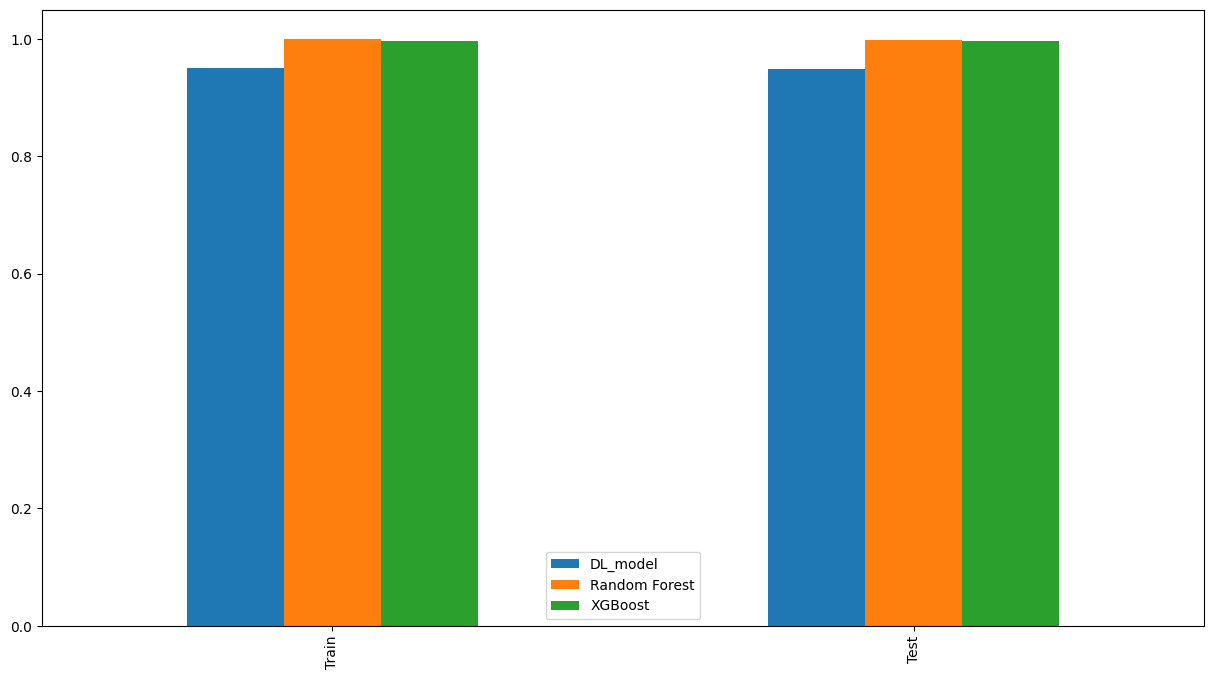

In [60]:
scores_df = pd.DataFrame(scores)

scores_df.plot(kind='bar', figsize=(15, 8))
scores